In [ ]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
# Loads YOLO bounding‐box crops as independent training samples,
# Resizes them to 224×224,
# Trains a VAE on those crops,
# Plots the 2D projection of the latent space (first two dims),
# Displays original vs. reconstructed crops.


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

# ─── Hyperparameters ──────────────────────────────────────────────────────
IMAGE_SIZE     = 224
IMAGE_CHANNELS = 3
LATENT_DIM     = 128
BATCH_SIZE     = 32
LR             = 1e-3
EPOCHS         = 10
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── Custom Dataset for YOLO Cropped Boxes ─────────────────────────────────
class YOLOCropDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.samples = []
        self.transform = transform
        for img_path in sorted(glob.glob(os.path.join(image_dir, "*.png"))):
            base = os.path.splitext(os.path.basename(img_path))[0]
            txt_path = os.path.join(label_dir, base + ".txt")
            if not os.path.exists(txt_path):
                continue
            img = Image.open(img_path)
            W, H = img.size
            with open(txt_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue
                    _, x_c, y_c, w, h = parts
                    x_c, y_c, w, h = map(float, (x_c, y_c, w, h))
                    x0 = int((x_c - w/2) * W)
                    y0 = int((y_c - h/2) * H)
                    x1 = int((x_c + w/2) * W)
                    y1 = int((y_c + h/2) * H)
                    self.samples.append((img_path, (x0, y0, x1, y1)))
        if len(self.samples) == 0:
            raise RuntimeError("No YOLO crops found. Check image_dir/label_dir.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, (x0, y0, x1, y1) = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        crop = img.crop((x0, y0, x1, y1))
        if self.transform:
            crop = self.transform(crop)
        return crop

# ─── Transforms ────────────────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# ─── Instantiate Datasets & Loaders ───────────────────────────────────────
train_dataset = YOLOCropDataset("images/train", "labels/train", transform)
test_dataset  = YOLOCropDataset("images/test",  "labels/test",  transform)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# ─── VAE Model ─────────────────────────────────────────────────────────────
class VAE(nn.Module):
    def __init__(self, in_channels=IMAGE_CHANNELS, latent_dim=LATENT_DIM):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1), nn.ReLU(),   # 224→112
            nn.Conv2d(32, 64, 4, 2, 1),      nn.ReLU(),       # 112→56
            nn.Conv2d(64,128, 4, 2, 1),      nn.ReLU(),       # 56→28
            nn.Conv2d(128,256,4, 2, 1),      nn.ReLU(),       # 28→14
            nn.Flatten()
        )
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, IMAGE_SIZE, IMAGE_SIZE)
            flat_dim = self.enc(dummy).shape[1]
        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, flat_dim)
        self.dec    = nn.Sequential(
            nn.Unflatten(1, (256,14,14)),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(),  # 14→28
            nn.ConvTranspose2d(128,64,4,2,1),  nn.ReLU(),  # 28→56
            nn.ConvTranspose2d(64,32,4,2,1),   nn.ReLU(),  # 56→112
            nn.ConvTranspose2d(32,in_channels,4,2,1), nn.Sigmoid()  # 112→224
        )

    def encode(self, x):
        h = self.enc(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        return mu + torch.randn_like(std) * std

    def decode(self, z):
        return self.dec(self.fc_dec(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        return self.decode(self.reparameterize(mu, logvar)), mu, logvar

# ─── Loss Function ─────────────────────────────────────────────────────────
def vae_loss(recon, x, mu, logvar):
    bce = F.binary_cross_entropy(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

# ─── Training Loop ─────────────────────────────────────────────────────────
model = VAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
os.makedirs("reconstructions", exist_ok=True)

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0
    for crops in train_loader:
        crops = crops.to(DEVICE)
        optimizer.zero_grad()
        recon, mu, logvar = model(crops)
        loss = vae_loss(recon, crops, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}/{EPOCHS} — Avg Loss: {total_loss/len(train_dataset):.4f}")

# ─── Evaluation: Latent Scatter and Reconstructions ────────────────────────
model.eval()
with torch.no_grad():
    # take one batch of test crops
    crops = next(iter(test_loader)).to(DEVICE)
    recon, mu, logvar = model(crops)  # mu and logvar are Latent Space
    z = mu.cpu().numpy()

# Plot latent space (first two dims)
plt.figure(figsize=(6,6))
plt.scatter(z[:,0], z[:,1], s=10)
plt.title("Latent Space (first 2 dims)")
plt.xlabel("z[0]"); plt.ylabel("z[1]")
plt.show()

# Plot original vs reconstructed crops
n = min(8, crops.size(0))
orig = crops[:n].cpu()
rec  = recon[:n].cpu()
comp = torch.cat([orig, rec], dim=0)
grid = utils.make_grid(comp, nrow=n)
plt.figure(figsize=(10,4))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title("Top row: Original crops — Bottom row: Reconstructions")
plt.show()



Epoch 1/5 — Avg Loss: 87028.1951
Epoch 2/5 — Avg Loss: 85283.2622
Epoch 3/5 — Avg Loss: 85106.8259
Epoch 4/5 — Avg Loss: 85061.2385
Epoch 5/5 — Avg Loss: 84971.2185


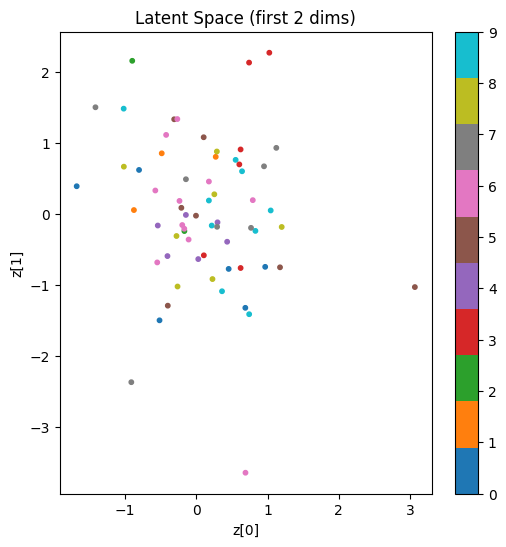

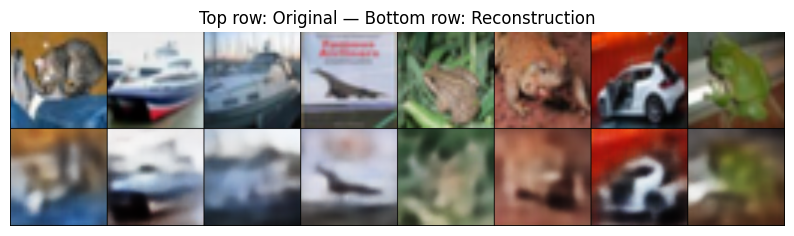

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import os

# ─── Hyperparameters ──────────────────────────────────────────────────────
IMAGE_SIZE     = 224
IMAGE_CHANNELS = 3
LATENT_DIM     = 128
BATCH_SIZE     = 16
LR             = 1e-3
EPOCHS         = 5
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── Data Pipeline ─────────────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])
train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader   = DataLoader(test_dataset,  batch_size=64,            shuffle=False, num_workers=0)

# ─── VAE Model ─────────────────────────────────────────────────────────────
class VAE(nn.Module):
    def __init__(self, in_channels=IMAGE_CHANNELS, latent_dim=LATENT_DIM):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1), nn.ReLU(),  # 224→112
            nn.Conv2d(32, 64, 4, 2, 1),      nn.ReLU(),  # 112→56
            nn.Conv2d(64,128, 4, 2, 1),      nn.ReLU(),  # 56→28
            nn.Conv2d(128,256,4, 2, 1),      nn.ReLU(),  # 28→14
            nn.Flatten()
        )
        # Determine flattened dimension
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, IMAGE_SIZE, IMAGE_SIZE)
            flat_dim = self.enc(dummy).shape[1]
        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, flat_dim)
        self.dec    = nn.Sequential(
            nn.Unflatten(1, (256,14,14)),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(),  # 14→28
            nn.ConvTranspose2d(128,64,4,2,1),  nn.ReLU(),  # 28→56
            nn.ConvTranspose2d(64,32,4,2,1),   nn.ReLU(),  # 56→112
            nn.ConvTranspose2d(32,in_channels,4,2,1), nn.Sigmoid()  # 112→224
        )

    def encode(self, x):
        h = self.enc(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = (0.5*logvar).exp()
        return mu + torch.randn_like(std)*std

    def decode(self, z):
        return self.dec(self.fc_dec(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        return self.decode(self.reparameterize(mu, logvar)), mu, logvar

def vae_loss(recon, x, mu, logvar):
    bce = F.binary_cross_entropy(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

# ─── Train Loop ────────────────────────────────────────────────────────────
model = VAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
os.makedirs("reconstructions", exist_ok=True)

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{EPOCHS} — Avg Loss: {avg_loss:.4f}")

# ─── Evaluation: Latent Scatter and Reconstructions ────────────────────────
model.eval()
# Gather one batch for scatter
imgs, labels = next(iter(test_loader))
imgs, labels = imgs.to(DEVICE), labels.numpy()

with torch.no_grad():
    mu, logvar = model.encode(imgs)        # mu, logvar are the latent space
    z = model.reparameterize(mu, logvar).cpu().numpy()


# Plot latent space (first 2 dims)
plt.figure(figsize=(6,6))
scatter = plt.scatter(z[:,0], z[:,1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("Latent Space (first 2 dims)")
plt.xlabel("z[0]"); plt.ylabel("z[1]")
plt.show()

# Reconstruction grid
n = 8
with torch.no_grad():
    recon, _, _ = model(imgs)
orig = imgs[:n].cpu()
rec  = recon[:n].cpu()
comp = torch.cat([orig, rec], dim=0)
grid = utils.make_grid(comp, nrow=n)
plt.figure(figsize=(10,4))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title("Top row: Original — Bottom row: Reconstruction")
plt.show()
